# Contraceptive Method Choice
Lab Assignment Four: Extending Logistic Regression

**_Jake Oien, Seung Ki Lee, Jenn Le_**

## Data Preparation and Overview

### Business Case

### Class Variables

Dataset Source: https://archive.ics.uci.edu/ml/datasets/Contraceptive+Method+Choice

This dataset is a subset of the 1987 National Indonesia Contraceptive Prevalence Survey. The samples are married women who were either not pregnant or do not know if they were at the time of interview. The problem is to predict the current contraceptive method choice (no use, long-term methods, or short-term methods) of a woman based on her demographic and socio-economic characteristics.

1. Wife's age (numerical) 
2. Wife's education (categorical) 1=low, 2, 3, 4=high 
3. Husband's education (categorical) 1=low, 2, 3, 4=high 
4. Number of children ever born (numerical) 
5. Wife's religion (binary) 0=Non-Islam, 1=Islam 
6. Wife's now working? (binary) 0=Yes, 1=No 
7. Husband's occupation (categorical) 1, 2, 3, 4 
8. Standard-of-living index (categorical) 1=low, 2, 3, 4=high 
9. Media exposure (binary) 0=Good, 1=Not good 
10. Contraceptive method used (class attribute) 1=No-use, 2=Long-term, 3=Short-term

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Here, we'll import the data and add column names
col_names = ["wife_age", 
             "wife_education", 
             "husband_education", 
             "num_children", 
             "wife_practices_islam", 
             "wife_working", 
             "husband_occupation",
             "sol_index",  # standard of living index
             "media_exposure",
             "contraceptive_method"
            ]
data = pd.read_csv("./cmc.csv", header=None, names=col_names, encoding='latin-1')

In [19]:
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 10 columns):
wife_age                1473 non-null int64
wife_education          1473 non-null int64
husband_education       1473 non-null int64
num_children            1473 non-null int64
wife_practices_islam    1473 non-null int64
wife_working            1473 non-null int64
husband_occupation      1473 non-null int64
sol_index               1473 non-null int64
media_exposure          1473 non-null int64
contraceptive_method    1473 non-null int64
dtypes: int64(10)
memory usage: 115.2 KB


,wife_age,wife_education,husband_education,num_children,wife_practices_islam,wife_working,husband_occupation,sol_index,media_exposure,contraceptive_method
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1
5,19,4,4,0,1,1,3,3,0,1
6,38,2,3,6,1,1,3,2,0,1
7,21,3,3,1,1,0,3,2,0,1
8,27,2,3,3,1,1,3,4,0,1
9,45,1,1,8,1,1,2,2,1,1


First, all of the data exists; there are no non-null values. 

Second, the `husband_occupation` field does not have a good description for the data. The only information about it is that it is a categorical field that can contain the values 1,2,3,4. Without more information, we will remove `husband_occupation` from the dataset. 

Third, the `wife_working` field has some non-intuitive inverted logic in it. In the dataset given, a 0 means working and a 1 means not working. We will flip those around so that now the dataset means that a 1 means working and a 0 means not working. Similarly, the `media_exposure` column uses a 0 to mean "Good" and a 1 to mean "Not good". We will also flip those values so that the lower number refers to a worse category. Also, the wife_working column has the same issue. 0 means working but we will make it mean not working. 

Finally, because our classifier isn't ordinal since 'long-term' comes between 'no use' and 'short-term', we'll one hot encode the values. This will happen later, though, right before our data split. For now, we'll keep the original values and take a look at some information regarding those values.

In [22]:
# remove husband_occupation
if "husband_occupation" in data:
    del data["husband_occupation"]
    
# flip 1s and 0s    1-1 = 0, 1-0 = 1
data["wife_working"] = 1-data["wife_working"]
data["media_exposure"] = 1-data["media_exposure"]

There are a few things we can look at regarding this data. To start, let's take a look at contraceptive use vs the number of children the wife has. 

Class Distribution
contraceptive_method
1    629
2    333
3    511
Name: num_children, dtype: int64

Class Distribution Grouped by Number of Children
contraceptive_method    1   2    3
num_children                      
0                      95   0    2
1                     143  46   87
2                     114  56  106
3                      70  70  119
4                      57  62   78
5                      44  36   55
6                      35  27   30
7                      18  19   12
8                      29   9    9
9                       5   3    8
10                      9   2    0
11                      6   2    3
12                      4   0    0
13                      0   1    1
16                      0   0    1


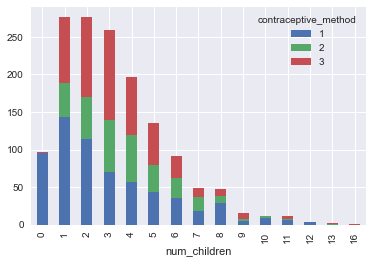

In [23]:
%matplotlib inline
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)

data_grouped_by_contraceptive_method = data.groupby(by=["contraceptive_method"])
num_children_by_contraceptive_method = pd.crosstab([data["num_children"]], data.contraceptive_method)

print("Class Distribution")
print(data_grouped_by_contraceptive_method.num_children.count())
print("\nClass Distribution Grouped by Number of Children")
print(num_children_by_contraceptive_method)

num_children_by_contraceptive_method.plot(kind="bar", stacked=True)

# fig, ax = plt.subplots()

# sns.distplot(data[data.contraceptive_method == 1].num_children, label="No use", ax=ax)
# sns.distplot(data[data.contraceptive_method == 2].num_children, label="Short-term use", ax=ax)
# sns.distplot(data[data.contraceptive_method == 3].num_children, label="Long-term use", ax=ax)

# plt.title("")
# plt.legend();

# sns.distplot()



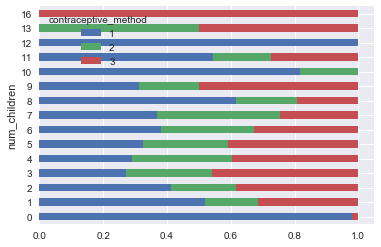

In [24]:
num_children_percentage = num_children_by_contraceptive_method.div(num_children_by_contraceptive_method.sum(axis=1).astype(float),
                             axis=0) # normalize the value

num_children_percentage.plot(kind="barh", stacked=True)

We can see that for wives with 0 children, contraceptive use is almost all "No use". As the number of children increases, we see that families with a smaller amount of children (1-3) start to increase in use of long-term contraceptive use. Similarly, after number of children gets to 3, short term contraceptive usage seems to increase in the percentage of the sampled population. 

One might think that contraceptive use would correspond with having less children, because women on birth control have less kids. However, contraceptive usage might actually be a response to family size. At a certain point, a family might decide their family is too big, and start using contraceptives to avoid their family getting larger. 

Another point to take a look at is the use of contraceptives related to education levels and standards of living. According to the paper found here https://www.jstor.org/stable/2138087, women's contraceptive usage tends to increase as their level of education increases. Additionally, a lower standard of living might mean that a women has less access to contraceptives and hence would tend towards "No use". 

contraceptive_method    1    2    3
sol_index                          
1                      80    9   40
2                     117   30   82
3                     184   90  157
4                     248  204  232


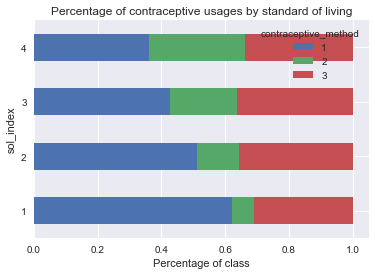

In [25]:
sol = pd.crosstab([data.sol_index], data.contraceptive_method)
print (sol)
# sol_and_education.plot(kind="bar", stacked=True)

sol_percentage = sol.div(sol.sum(axis=1).astype(float),
                             axis=0) # normalize the value

sol_percentage.plot(kind="barh", stacked=True)
plt.title("Percentage of contraceptive usages by standard of living");
plt.xlabel("Percentage of class");

One thing to note from the table here is the increase in number of women surveyed as the standard of living increases. We can see clearly from this graph that as the standard of living goes up, use of contraceptives goes up. Long-term contraceptive usage appears to stay relatively constant. 

Finally, let's look at education and contraceptive use. 

contraceptive_method    1    2    3
wife_education                     
1                     103    9   40
2                     176   37  121
3                     175   80  155
4                     175  207  195


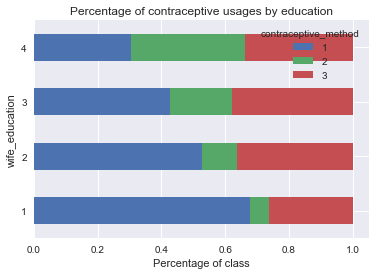

In [26]:
education = pd.crosstab([data.wife_education], data.contraceptive_method)
print (education)
# sol_and_education.plot(kind="bar", stacked=True)

education_percentage = education.div(education.sum(axis=1).astype(float),
                             axis=0) # normalize the value

education_percentage.plot(kind="barh", stacked=True)
plt.title("Percentage of contraceptive usages by education")
plt.xlabel("Percentage of class")

As before, we see that as education level of the woman goes up, "No use" of contraceptive goes down. This is in line with much research on the impact of education on contraceptive use. 

Finally, let's see how all of the other variables relate to one another. 

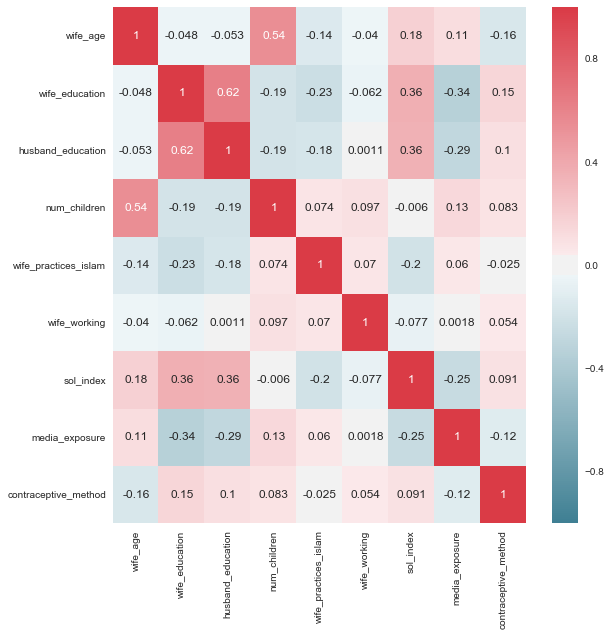

In [27]:
# plot the correlation matrix using seaborn
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings
sns.set(style="darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize=(9, 9))

sns.heatmap(data.corr(), cmap=cmap, annot=True, center=0)

f.tight_layout()

From this heatmap we see a few strong correlations. The strongest correlation is that between the husband's education and the wife's education. It would make sense that a couple would tend to have similar education levels, or at least that as one member of the couple trends towards higher education that the other would trend toward higher education. 

Additionally, we see that the next highest correlation is that between wife_age and num_children. Younger women simply haven't had as much time as other women to have children. 

Related to contraceptive method, we see that the correlations above 0.1 include media exposure, and husband/wife education. These are overall pretty weak correlations, but that doesn't mean that the data cannot be predicted. Correlation measurements measure a linear relationship between variables, and they might not actually have an underlying linear relationship. That's what we will find out with logistic regression. 

### Data Division

We will now split the data into a training set and a testing set. This is also where we will save the one hot encoding of the data. We will use an 80/20 split. This split is appropriate for this specific dataset as each class has a fairly large amount of records associated with it. Because of this, we don't have much of an issue with having enough representative data even though there is almost twice as many 'no use' cases than 'long-term'cases. However, we also don't have very much data so we could have a higher percentage of training data without taking up much time.

In [28]:
X = data.drop("contraceptive_method", axis=1).as_matrix()
y = pd.get_dummies(data["contraceptive_method"])

print(X.shape)
print(y.shape)

(1473, 8)
(1473, 3)


In [29]:
from sklearn.cross_validation import train_test_split
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
print("Training set has {} instances".format(len(X_train)))
print("Testing set has {} instances".format(len(X_test)))
print("The whole set has {} instances".format(len(X_train) + len(X_test)))

Training set has 1178 instances
Testing set has 295 instances
The whole set has 1473 instances


## Modeling

### Custom Logistic Regression Classifier

To implement a custom logistic regression classifier, we'll first define the basic classes we'll need and their functions. These were taken from the class notebook on logistic optimization.

In [30]:
import numpy as np
from scipy.special import expit


class BinaryLogisticRegressionBase:
    # private:
    def __init__(self, eta, iterations=20):
        self.eta = eta
        self.iters = iterations
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    
    def __str__(self):
        return 'Base Binary Logistic Regression Object, Not Trainable'
    
    
    # convenience, private:
    @staticmethod
    def _sigmoid(theta):
        return 1/(1+np.exp(-theta)) 
    
    
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    
# inherit from base class
class BinaryLogisticRegression(BinaryLogisticRegressionBase):
    #private:
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'

        
    def _get_gradient(self,X,y):
        # programming \sum_i (yi-g(xi))xi
        gradient = np.zeros(self.w_.shape) # set gradient to zero
        for (xi,yi) in zip(X,y):
            # the actual update inside of sum
            gradi = (yi - self.predict_proba(xi,add_bias=False))*xi 
            # reshape to be column vector and add to gradient
            gradient += gradi.reshape(self.w_.shape) 
        
        return gradient/float(len(y))
       
        
    # public:
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 
            
            
class VectorBinaryLogisticRegression(BinaryLogisticRegression):
    # inherit from our previous class to get same functionality
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    
    # but overwrite the gradient calculation
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        return gradient.reshape(self.w_.shape)


class LogisticRegression:
    def __init__(self, eta, iterations=20):
        self.eta = eta
        self.iters = iterations
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = [] # will fill this array with binary classifiers
        
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = y==yval # create a binary problem
            # train the binary classifier for this class
            blr = VectorBinaryLogisticRegression(self.eta,self.iters)
            blr.fit(X,y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for blr in self.classifiers_:
            probs.append(blr.predict_proba(X)) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1) # take argmax along row

Here we'll define our own logistic regression classifier. We allow for method, cost, and regularization to be passed in as parameters to allow for our classifier to be adjusted and its performance to be examined. We've definied the stochastic gradient descent, newton, and steepest descent methods within our regularized binary logistic regression class.

Our one-versus-all logistic regression classifier is then defined by making use of our regularized binary logistic regression class. In order to make our implementation compatible with GridSearchCV, we'll also implement methods defined by scikit-learn's estimator interface.

In [31]:
from numpy import seterr
from sklearn.metrics import accuracy_score

np.seterr(over='print')

class RegularizedBinaryLogisticRegression(BinaryLogisticRegression):
    def __init__(self, method="steepest", C=0.1, reg="L1", eta=0.1, **kwargs):
        self.method = method
        self.C = C
        self.reg = reg
        super().__init__(eta=eta, **kwargs)

    def _get_stochastic_gradient(self, X, y):
        idx = int(np.random.rand()*len(y)) # grab random instance
        ydiff = y[idx]-self.predict_proba(X[idx],add_bias=False) # get y difference (now scalar)
        gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        
        
        return gradient
    
    def _get_newton_method_gradient(self,X,y):
        g = self.predict_proba(X,add_bias=False).ravel() # get sigmoid value for all classes
        hessian = X.T @ np.diag(g*(1-g)) @ X - 2 * self.C # calculate the hessian

        ydiff = y-g # get y difference
        gradient = np.sum(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        
        return pinv(hessian) @ gradient
    
    def _get_steepest_descent_gradient(self, X, y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
#         gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = np.mean(X * ydiff[:,np.newaxis] + self.C*np.sum(self.w_), axis=0) # make ydiff a column vector and multiply through

        
        return gradient.reshape(self.w_.shape)
    
    def _get_gradient(self, X, y):
        if self.method == "stochastic":
            gradient = self._get_stochastic_gradient(X, y)
        elif self.method == "newton":
            gradient = self._get_newton_method_gradient(X, y)
        elif self.method == "steepest":
            gradient = self._get_steepest_descent_gradient(X, y)
        else:
            return
        
        if self.reg == "L2":
            # derivative of the L2 Norm of the weights, exclude bias term  piecewise function np.sign
            gradient[1:] += -2 * self.w_[1:] * self.C  
        elif self.reg == "L1":
            gradient[1:] += np.sign(self.w_[1:]) * self.C  # exclude bias term
        elif self.reg == "L1L2":
            gradient[1:] += (np.sign(self.w_[1:]) * self.C) + (-2 * self.w_[1:] * self.C)
        else:
            pass
                
        return gradient
        

class RegularizedLogisticRegression(LogisticRegression):
    def __init__(self, eta=0.1, iters=20, method="steepest", C=0.5, reg="L1", **kwargs):
        self.eta = eta
        self.C = C
        self.method = method
        self.reg = reg
        self.iters = iters
        
        super().__init__(eta=eta, iterations=iters, **kwargs)
        
    # methods for estimator interface
    def get_params(self, deep=True):
        return {"method": self.method, "C": self.C, "reg": self.reg}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            self.__setattr__(parameter, value)
        return self
    
    def score(self, X, y):
        y_hat = self.predict(X)
        return accuracy_score(y,y_hat)
        
    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = [] # will fill this array with binary classifiers
        
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = y==yval # create a binary problem
            # train the binary classifier for this class
            blr = RegularizedBinaryLogisticRegression(eta=self.eta,iterations=self.iters)
            blr.fit(X,y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T

### Training

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

rlr = LogisticRegression(eta=5, iterations=500)
rlr.fit(X_train, y_train)

yhat = rlr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))
print(y)
print(yhat)

ValueError: Unable to coerce to Series, length must be 3: given 1178

In [ ]:
rlr = RegularizedLogisticRegression(eta=0.1, reg="L1", method="steepest", C=0.1, iters=50)
rlr.fit(X_train, y_train)

yhat = rlr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))
print(yhat)

In [ ]:
rlr = RegularizedLogisticRegression(eta=0.1, reg="L1", method="newton", C=0.1, iters=50)
rlr.fit(X_train, y_train)

yhat = rlr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

### Comparison